# Named Entity Recognition (Deep Learning, LSTM)

Named Entity Recognition (NER) is a sequence labelling task: Given a sequence of word, we want to assign each word with a label which indicates whether the word is or is part of a named entity. There are different machine learning approaches to solve sequence labelling, including Hidden Markov Chains, Conditional Random Fields, etc. Using deep learning, the recurrent network model can be sketched as follows:

<img src="images/rnn-many-to-many-sequence-labelling.png" alt="Drawing" style="width: 60%;"/>

In contrast to traditional sentiment analysis, we no longer just assign one label/class to a sentences but one label/class to each word in the sentence. As you will see in the following, the most effort will be in the data preparation to get a dataset into the shape to serve as input and output for the deep learning network.

## Import required packages

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Activation, Embedding, Dense, Bidirectional
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

Using TensorFlow backend.


## Data preperation

### Read dataset file

If you look into the text file `data/ner-dataset/wikigold.conll.txt` you can see that each line contains a word-label pair seperated by a whitespace. Consecutive pairs form a sentence, and sentences are separated by an empty line. In the following loop, we read the text file line by line, connect word-label pairs so sentences and organize all sentences in to a list `sequences`:

In [2]:
sequences = []
sentence = []

with open('data/ner-dataset/wikigold.conll.txt') as f:
    for line in f:
        stripped_line = line.strip().split(' ')
        #stripped_line = line.strip().lower().split(' ') # You can use this line instead to see the effect to make all words lowercase
        
        if len(stripped_line) == 2: # Add only valid word-label pairs to sentence list
            sentence.append(stripped_line)
        
        if line == '\n': # In this case, we have reached the end of the current sentence
            sequences.append(sentence) # Add current sentence to overall list
            sentence = []              # Clear current sentence list
        
print('Number of sequences: {}'.format(len(sequences)))
print()
print(sequences[0])

UnicodeDecodeError: 'gbk' codec can't decode byte 0xa0 in position 4437: illegal multibyte sequence

### Remove overly long sequences

There is the intrinsic goal to keep the maximum length of sequences small since this number represents the number of time steps for the recurrent neural network (here: LSTM) which in turn heavily affects the training performance. 

In [3]:
sequence_lengths = [ len(x) for x in sequences ] 
max_seq_len = max(sequence_lengths)

print(max_seq_len)

83


We can also plot the distrubtion of sequence lengths using a histogram. There we can check what might be a good cut-off threshold that (a) minimizes the maximum sequence length but (b) still keeps most of the data we need for the training.

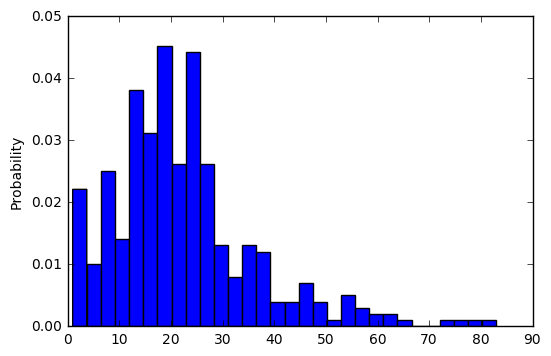

In [4]:
%matplotlib inline

plt.hist(sequence_lengths, normed=True, bins=30)
plt.ylabel('Probability');

Base on this graph, we can easily kick out all sequences longer than 64 words.

In [5]:
short_sequences = [ s for s in sequences if len(s) <= 64 ]

print('Number of short sequences: {}'.format(len(short_sequences)))

Number of short sequences: 360


Just to make a sanity check, let's calculate the longest sequence again. The results shouldn't be surprising...

In [6]:
max_seq_len = max([ len(x) for x in short_sequences ])

print(max_seq_len)

64


### Split data in the input sequences and label sequences

`short_sequences` is a list which itself contains lists (i.e., each sentence) of lists (i.e., each word-label pair). We need to split th data in to `X` as the list of sentences and `y` as the list of labels.

In [7]:
X = [[c[0] for c in x] for x in short_sequences]
y = [[c[1] for c in y] for y in short_sequences]

For an example, let's see the words and respective labels of the first item.

In [8]:
print(X[0])
print(y[0])

['010', 'is', 'the', 'tenth', 'album', 'from', 'Japanese', 'Punk', 'Techno', 'band', 'The', 'Mad', 'Capsule', 'Markets', '.']
['I-MISC', 'O', 'O', 'O', 'O', 'O', 'I-MISC', 'O', 'O', 'O', 'I-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O']


### Calculate vocabulary and list of labels

We first extract all words and all labels from all sequences. Note that these list contain the same word or label multiple times.

In [9]:
full_word_list = [c for x in X for c in x]
full_label_list = [c for x in y for c in x] # A bit overkill since we know the 5 available labels

Using the `set()` constructor on both lists is an easy way to convert the lists into sets, which means that duplicates will automatically be removed.

In [10]:
vocabulary = list(set(full_word_list))
labels =  list(set(full_label_list))

print('Size of vocabulary: {}'.format(len(vocabulary)))
print()
print('Number of labels: {}'.format(len(labels)))
print(labels)

Size of vocabulary: 2395

Number of labels: 5
['I-LOC', 'O', 'I-ORG', 'I-MISC', 'I-PER']


### Define mappings between words/indexes and labels/indexes

Since the network take words but integers as input and output we have to define mappings that map words and labels to unique indexes (i.e., integer values), and vice versa. 

**Important:** We have to reserve word index 0 to a special word, e.g., "<PAD>". Below, we again need to pad short sequences. Since the padding is done with 0's, we have to ensure that 0 is not associated with proper word from the dictionary.

In the tutorial for sentiment analysis using deep learning, we could use the tokenizer provided by Keras which conveniently created the require mapping(s). Here it is actually easier to to it "manually".

In [12]:
word_to_idx = {word: (idx + 2) for idx, word in enumerate(vocabulary)}
idx_to_word = {(idx + 2): word for idx, word in enumerate(vocabulary)}

# Explicitly set the index of the "<PAD>" token
word_to_idx['<PAD>'] = 0
idx_to_word[0] = '<PAD>'

word_to_idx['<UNK>'] = 1
idx_to_word[1] = '<UNK>'


label_to_idx = {label: (idx + 1) for idx, label in enumerate(labels)}
idx_to_label = {(idx + 1): label for idx, label in enumerate(labels)}

print(word_to_idx['the'], idx_to_word[4978])
print(label_to_idx['I-LOC'], idx_to_label[3])
print()
print(word_to_idx['<PAD>'], idx_to_word[0])

KeyError: 4978

### Encode word and label sequences

With the mappings we can now encode the words sequences and pad them so they all have the same length `max_seq_length`.

In [13]:
X_encoded = [[word_to_idx[word] for word in sentence] for sentence in X]
X_encoded = pad_sequences(X_encoded, maxlen=max_seq_len, padding='post')

print(X[0])
print(X_encoded[0])

['010', 'is', 'the', 'tenth', 'album', 'from', 'Japanese', 'Punk', 'Techno', 'band', 'The', 'Mad', 'Capsule', 'Markets', '.']
[ 870 1217  481 1692 1161  742 1297 1153 1728  594   65  987  596  392
 1749    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


Note in the example above that "the" and "The" are considered different words. For NER it is often beneficial not to lowercase all words since named entities are often capitalized. In formal text, this assumption typical holds. In informal text like social media, people are typically less careful when it comes to proper capitalization.

Encoding the labels is a bit more tricky, since each label needs to be encoded as a one-hot vector instead of a single integer value -- the word indexs will eventually also be converted into word vectors, but this will be done by the `Embedding` layer in the network model.

In [14]:
# Utility function that returns an array of size n, where all elements are zero except at position x, where it is 1.
# (i.e., it creates a one-hot encoding for an individual label)
def encode(x, n):
    result = np.zeros(n)
    result[x] = 1
    return result

# Same as for X_encoded: map label to index and pad to length max_seq_length              
y_encoded = [ [label_to_idx[label] for label in label_seq] for label_seq in y ]
y_encoded = pad_sequences(y_encoded, maxlen=max_seq_len, padding='post')
print(y_encoded[0])
print()

# Convert each label index to the corresponding one-hot index
y_encoded = [ [encode(label, len(labels)+1) for label in label_seq] for label_seq in y_encoded]
print(y_encoded[0][:3])
print()


[4 2 2 2 2 2 4 2 2 2 3 3 3 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[array([0., 0., 0., 0., 1., 0.]), array([0., 0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0.])]



In [15]:
print(label_to_idx)

{'I-LOC': 1, 'O': 2, 'I-ORG': 3, 'I-MISC': 4, 'I-PER': 5}


In [16]:
X_encoded = np.array(X_encoded)
y_encoded = np.array(y_encoded)

### Split data into training and test data

`scitkit-learn` provides a convenient method to split the data into training and test data given a user-defined ratio.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.1)

print('Size of training set: {}'.format(len(X_train)))
print('Size of test set: {}'.format(len(X_test)))

print()
print(X_train.shape)
print(X_train[0])

Size of training set: 324
Size of test set: 36

(324, 64)
[1195  667 2118 1707  481 1290  706 2144 1053  481 1674 1051 1418  180
  174  841  481  983 1876 1587 1749    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


## Training the model

We have to specify a set of parameters for the network. You can change those value to see the effects on the accuracy and performace.

In [18]:
LSTM_HIDDEN_DIM = 32
EMBEDDING_DIM = 128

max_features = len(vocabulary) + 2 # +1 because we added the word '<PAD>'; +1 because we added the word '<UNK>'
out_size = len(labels) + 1

### Define the model

We define a common network structure containing

- an embedding layer
- a bi-directional LSTM layer
- a fully connected (dense) layer as output for **each time step** (hence `TimeDistributed`)
- a softmax layer to normalize the output to probabilities (again, for each time step)

In [19]:
model = Sequential()
model.add(Embedding(max_features, EMBEDDING_DIM, input_length=max_seq_len, mask_zero=True))
model.add(Bidirectional(LSTM(LSTM_HIDDEN_DIM, return_sequences=True)))
model.add(TimeDistributed(Dense(out_size)))
model.add(Activation('softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 64, 128)           306816    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64, 64)            41216     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 64, 6)             390       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 6)             0         
Total params: 348,422
Trainable params: 348,422
Non-trainable params: 0
_________________________________________________________________
None


### Compile the model

In [20]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

### Train the model

In [21]:
history = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1, validation_split=0.1)

Train on 291 samples, validate on 33 samples
Epoch 1/100
291/291 [==============================] - 4s 12ms/step - loss: 1.7379 - val_loss: 1.6155
Epoch 2/100
291/291 [==============================] - 1s 4ms/step - loss: 1.4899 - val_loss: 1.1512
Epoch 3/100
291/291 [==============================] - 1s 4ms/step - loss: 0.9475 - val_loss: 0.6357
Epoch 4/100
291/291 [==============================] - 1s 4ms/step - loss: 0.8290 - val_loss: 0.6131
Epoch 5/100
291/291 [==============================] - 1s 4ms/step - loss: 0.7323 - val_loss: 0.6057
Epoch 6/100
291/291 [==============================] - 1s 4ms/step - loss: 0.6859 - val_loss: 0.5824
Epoch 7/100
291/291 [==============================] - 1s 4ms/step - loss: 0.6442 - val_loss: 0.5400
Epoch 8/100
291/291 [==============================] - 1s 4ms/step - loss: 0.6008 - val_loss: 0.5138
Epoch 9/100
291/291 [==============================] - 1s 4ms/step - loss: 0.5538 - val_loss: 0.4857
Epoch 10/100
291/291 [=======================

### Evaluate the model

We can use the in-built method `evaluate()` as usual to calculate the overall accuracy of the model over the test set. However, be aware that we do not simple check of a single class has been predicted currectly. Here, 100% accuracy would now mean that the label for each word in all sequences is correct.

In [22]:
score = model.evaluate(X_test, y_test, batch_size=32, verbose=1)
print(score)

36/36 [==============================] - 0s 1ms/step
0.45314064290788436


The results look pretty good. Note that the evaluate can also be application specific. For example, let's take the following sentence "I stay in the Hilton Hotel", and the phrase "The Hilton Hotel" is labeled as "I-LOC" in our dataset. If the our model only label "Hilton Hotel" as a location, it would not be 100% correct. One can arguem, however, that this results is correct (enough).



In [23]:
# Pick a random position of an item in the test data
sample_pos = 10

# Get the word and label sequence at that position
sample_seq = np.asarray([X_test[sample_pos]])
sample_labels = np.asarray(y_test[sample_pos])

# Convert to a word sequence and get the label
word_list = [ idx_to_word[idx] for idx in sample_seq[0] ]
label_list = [ np.argmax(label_seq) for label_seq in sample_labels ]

print(sample_seq)

# Use the trained model to predict the labels for the sample sequence
y_pred = model.predict_classes([sample_seq])

# Print the word, the predicted label and the true label for each word
for i, word in enumerate(word_list):
    if word == '<PAD>':
        break # If we reach the end of the "real" words, we can stop
    print(word, idx_to_label[y_pred[0][i]], idx_to_label[label_list[i]])

[[1292  493 1473 1173 1116 1173 1064 2207   90 1707  481 1170 1998 1053
   768 1749    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]
Five O O
months O O
later O O
, O O
however O O
, O O
it O O
did O O
participate O O
in O O
the O O
2nd O I-MISC
Battle I-MISC I-MISC
of I-MISC I-MISC
Fredericksburg I-MISC I-MISC
. O O


## Application use case: extracting named entities from news articles

In a previous tutorial we used NLTK and spaCy to extract named entities from news articles. We can now perform this task using our own trained network model.

### Import required packages

We first need some more packages to fetch news articles and to handle the raw text.

In [24]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from newspaper import Article

### Utility method

The following method takes a `sentence` and extracts all found named entities using a traind `model` and the respective `word_to_idx` and `idx_to_label`. The first part convets the sentence into sequence the model understand and predicts the labels; see above example code. The second part - the loop - essentially goes trough the whole sequence to form the output as a list of named entities (phrase + label).

In [25]:
def extract_named_entities(sentence, model, word_to_idx, idx_to_label):
    # Tokenize sentence
    seq = word_tokenize(sentence)
    # Encode words using the word-to-index mapping
    seq_encoded = [ word_to_idx[w] if w in word_to_idx else 1 for w in seq ] # Recall: 1 == <UNK>
    # Generate final input data by padding the sequence (and truncating if needed!!!)
    X = pad_sequences([seq_encoded], maxlen=max_seq_len, padding='post', truncating='post')

    # Use the trained model to predict the labels for the sample sequence
    y_pred = model.predict_classes([X], verbose=0)

    # Initialize some variables
    named_entities, phrase, current_label = [], [], 0
    for i, word in enumerate(seq):
        if word == '<PAD>':
            break # If we reach the end of the "real" words, we can stop
        # Get predicted label for the current word
        label = idx_to_label[y_pred[0][i]]
        if label != 'O':
            phrase.append(word)
        else:
            if len(phrase) > 0:
                named_entities.append((' '.join(phrase), current_label))
            phrase = []
        # Update current label
        current_label = label
        
    # Don't forget named entities at the very end even if there is not punctuation mark
    if len(phrase) > 0:
        named_entities.append((' '.join(phrase), current_label))

    return named_entities

A simple example regarding the usage of `extract_named_entities`...

In [26]:
sentence = "Tarzan likes to stay at The Hilton Hotel"

named_entities = extract_named_entities(sentence, model, word_to_idx, idx_to_label)

print(named_entities)

[('Hotel', 'I-ORG')]


### Analyzing news articles

Again, we use the `newspaper` package to easily fetch an online news article and extract the main content.

In [27]:
url = 'http://www.straitstimes.com/asia/east-asia/now-its-japans-turn-to-brace-for-a-monster-storm-as-typhoon-lan-nears'
#url = 'http://www.straitstimes.com/singapore/ammonia-leak-in-food-factory-at-fishery-port-road-3-taken-to-hospital'
#url = 'http://www.straitstimes.com/singapore/police-car-mounts-divider-in-accident-in-kampong-bahru-road-no-injuries'

article = Article(url)

In [28]:
article.download()
article.parse()

title = article.title
text = article.text

We trained our model of sequences of a maximum length of 64 words. We therefore cannot / should not give the whole content to the model but do it sentence by sentence. To split the content into sentences, we can simply use the `sent_tokenize()` method of NLTK.

In [29]:
sentences = sent_tokenize(text)

Lastly, we can loop over each sentence and extract all named entities for each sentence

In [30]:
for sent in sentences:
    named_entities = named_entities = extract_named_entities(sent, model, word_to_idx, idx_to_label)
    print('{}\n{}\n\n'.format(sent, named_entities))

NEW YORK (BLOOMBERG) - Seems like no one can escape nature's wrath these days.
[('nature', 'I-MISC')]


Typhoon Lan is forecast to grow into a monster storm south of Japan before it weakens on its approach to the island nation next week.
[]


It come on the heels of Ophelia, which brought gale-force winds to southern Ireland Monday, Maria, which devastated Puerto Rico, and Irma, Harvey and Nate, which struck the US Gulf Coast or Florida.
[('Ireland', 'I-PER'), ('Harvey', 'I-PER')]


That's not to mention two hurricanes that recently struck Mexico.
[]


Lan's top winds could reach 138 miles (222 kilometers) per hour Saturday, which would make it the equivalent of a Category 4 hurricane on the five-step Saffir-Simpson scale, according to the Joint Typhoon Warning Center in Hawaii.
[('Warning', 'I-PER')]


As it nears the Tokyo-Yokohama area, winds will probably weaken to about 109 mph, making it a Category 2 storm.
[]


Lan isn't the first big storm for Japan this season.
[]


It was str

### Analysis of results

The results are not bad at all but (of course) far from perfect. There are a couple of reasons for that:

- We trained over a very small dataset. 1,500 sentences are arbitrary unlikely to contain enough information and a variety to contain all common language structures that indicate a named entity.
- With the small dataset comes also a small vocabulary. As such, the will model often have to deal with unknown words.